## Build Convolutional Neural Network from scratch using PyTorch

- Convolutional Neural Network
- PyTorch
- FashionMNIST Dataset

## Loading required libraries

In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

## Changing current working directory

In [25]:
ROOT = "/content/drive/MyDrive/Deep Learning(@ineuron)/PyTorch"
os.chdir(ROOT)

## Defining a Configuration class
- Here we will be describing or mentioning all required hyper parameters and root data directory along with device (CPU or GPU)

In [26]:
class Config:
  def __init__(self):
    self.ROOT_DATA_DIR = "FashionMNISTDir"
    self.EPOCH = 10
    self.BATCH_SIZE = 32
    self.LEARNING_RATE = 0.01
    self.IMAGE_SIZE = (28, 28)
    self.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"This notebook is using device: {self.DEVICE}")
    self.SEED = 2022
    

config = Config()

This notebook is using device: cuda


## Downloading train and test data using tensorflow datasets.
- Here we will be using FashionMNIST dataset

In [27]:
train_data = datasets.FashionMNIST(
    root = config.ROOT_DATA_DIR,
    train = True,
    download = True,
    transform = transforms.ToTensor()

)


test_data = datasets.FashionMNIST(
    root = config.ROOT_DATA_DIR,
    train = False,
    download = True,
    transform = transforms.ToTensor()

)

In [28]:
## train data shape
train_data.data.shape

torch.Size([60000, 28, 28])

- We have total 60k train image of single channel with size 28 X 28

In [29]:
## test data shape
test_data.data.shape

torch.Size([10000, 28, 28])

- We have 10k test image

In [30]:
## checking train data classes index
train_data.class_to_idx

{'Ankle boot': 9,
 'Bag': 8,
 'Coat': 4,
 'Dress': 3,
 'Pullover': 2,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'T-shirt/top': 0,
 'Trouser': 1}

- Total 10 classes we have here.
- with train_data.class_to_idx we get index for each class.
- but this dictionary is opposite, it should be like 1: "Trouser"
- we have to correct it to make a label amp for further use

In [31]:
## we can see how train targets looks like
## therefore we need to make a label map where we give target and we should get class name
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

## Creat a label map for target classes along with their index

In [32]:
## this is given label map
given_label_map = train_data.class_to_idx
given_label_map

{'Ankle boot': 9,
 'Bag': 8,
 'Coat': 4,
 'Dress': 3,
 'Pullover': 2,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'T-shirt/top': 0,
 'Trouser': 1}

In [33]:
## making opposite of given label map dictionary comprehension
label_map = {val: key for key, val in given_label_map.items()}
label_map

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

## Visualize one of the samples

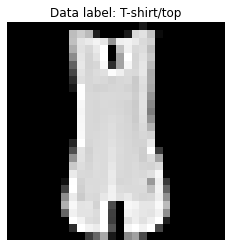

In [34]:
def view_sample_img(data, idx, label_map):
  plt.imshow(data.data[idx], cmap="gray")
  plt.title(f"Data label: {label_map[data.targets[idx].item()]}")
  plt.axis("off")

view_sample_img(train_data, 4, label_map)

## Create the dataloader

In [35]:
## train data loader
train_data_loader = DataLoader(
    dataset = train_data,
    batch_size = config.BATCH_SIZE,
    shuffle = True
)

## test data loader
test_data_loader = DataLoader(
    dataset = test_data,
    batch_size = config.BATCH_SIZE,
    shuffle = False
)

In [36]:
## lets do a check what we get from data loader
for image, label in test_data_loader:
  print(image.shape)
  print(label.shape)
  break

torch.Size([32, 1, 28, 28])
torch.Size([32])


- data loader gives image and label
- in one time it gives as many images as mentioned in batch size
- for now it is provinding 32 images and 32 labels for respective images
- all images are of single channel with size 28 X 28 

In [37]:
## lets check the shape of one image
image[0].shape

torch.Size([1, 28, 28])

- 1 stand for gray channel
- 28 X 28 is the size of image

In [38]:
## we can use squeeze to change the dimension of image
## Removes dimensions of size 1 from the shape of a tensor.
## we need to perform squeeze operation because sometime some library takes image dimension in different way
image[0].squeeze().shape

torch.Size([28, 28])

- After squeezing 1 from the shape of a tensor get removed
- only 28 X 28 size of image is there

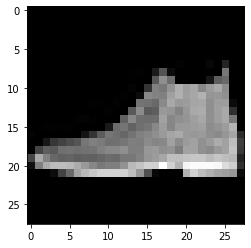

In [39]:
## matplotlib lib takes image dimension in this way (28 X 28)
## without squeezing it will give error
plt.imshow(image[0].squeeze(), cmap = "gray")
plt.show()

## BUILD THE NEURAL NETWORK:

- Neural networks comprise of layers/modules that perform operations on data. 
- The torch.nn namespace provides all the building blocks we need to build our own neural network. 
- Every module in PyTorch subclasses the nn.Module. A neural network is a module itself that consists of other modules (layers). 
- This nested structure allows for building and managing complex architectures easily.

In [40]:
class CNN(nn.Module):
  def __init__(self, in_, out_):
    super(CNN, self).__init__()

    self.conv_pool_01 = nn.Sequential(
        nn.Conv2d(in_channels=in_, out_channels=8, kernel_size=5, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
      
    )

    self.conv_pool_02 = nn.Sequential(
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, stride=1, padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
      
    )

    self.Flatten = nn.Flatten()
    self.FC_01 = nn.Linear(in_features=16*4*4, out_features=128)
    self.FC_02 = nn.Linear(in_features=128, out_features=64)
    self.FC_03 = nn.Linear(in_features=64, out_features=out_)

    
  def forward(self, x):
    x = self.conv_pool_01(x)
    x = self.conv_pool_02(x)
    x = self.Flatten(x)
    x = self.FC_01(x)
    x = F.relu(x)
    x = self.FC_02(x)
    x = F.relu(x)
    x = self.FC_03(x)
    return x

In [41]:
model = CNN(1, 10)

## check summary of the model
print(model)

CNN(
  (conv_pool_01): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_pool_02): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (FC_01): Linear(in_features=256, out_features=128, bias=True)
  (FC_02): Linear(in_features=128, out_features=64, bias=True)
  (FC_03): Linear(in_features=64, out_features=10, bias=True)
)


In [42]:
model.conv_pool_01

Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [43]:
## lets iterate through model.parameters
next(model.parameters())

Parameter containing:
tensor([[[[ 0.1466,  0.1371,  0.1257,  0.1246, -0.1708],
          [-0.1601, -0.1789, -0.0678,  0.1023, -0.1825],
          [ 0.0994,  0.1513,  0.1997, -0.1976, -0.0445],
          [ 0.1932, -0.1148,  0.0880, -0.1645,  0.1642],
          [-0.0369,  0.1452, -0.1694, -0.1357, -0.1629]]],


        [[[-0.0111,  0.0546, -0.1471, -0.1206, -0.1423],
          [ 0.0363, -0.0969,  0.1944,  0.0085, -0.1769],
          [-0.1625,  0.1937, -0.0041, -0.1753, -0.1216],
          [-0.1732,  0.1891,  0.0082,  0.0006, -0.1488],
          [ 0.0659,  0.1900,  0.1248,  0.0345, -0.1846]]],


        [[[ 0.0823, -0.0766, -0.0974, -0.1532,  0.0761],
          [-0.1598, -0.0081,  0.1241,  0.1928, -0.1837],
          [ 0.0954, -0.1495, -0.0583, -0.0318, -0.1105],
          [ 0.1032, -0.1010, -0.1292, -0.0402,  0.0858],
          [ 0.0297,  0.0133,  0.1905, -0.1106, -0.0165]]],


        [[[-0.1937,  0.1854,  0.0943,  0.1812,  0.0119],
          [ 0.1402,  0.0255, -0.0976, -0.0805, -0.1130

In [44]:
## lets check whether model is on GPU or not
next(model.parameters()).is_cuda

False

- Model parameters are not on GPU
- We can move model to GPU if available so that we will be using GPU for fast tensor calculation

In [45]:
## moving model to Device which we have configured above (GPU)
model.to(config.DEVICE)

CNN(
  (conv_pool_01): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_pool_02): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Flatten): Flatten(start_dim=1, end_dim=-1)
  (FC_01): Linear(in_features=256, out_features=128, bias=True)
  (FC_02): Linear(in_features=128, out_features=64, bias=True)
  (FC_03): Linear(in_features=64, out_features=10, bias=True)
)

In [46]:
## again checking model is on GPU or not
next(model.parameters()).is_cuda

True

- We succesfully transferred model from CPU to GPU device

## Count the no. of trainable  and non-trainable parameters

In [47]:
def count_params(model):
  model_params = {"Modules": list(), "Parameters": list()}
  total = {"trainable": 0, "non_trainable": 0}
  for name, parameters in model.named_parameters():
    param = parameters.numel()
    if not parameters.requires_grad:
      total["non_trainable"] += param
      continue
    param = parameters.numel()
    model_params["Modules"].append(name)
    model_params["Parameters"].append(param)
    total["trainable"] += param

  df = pd.DataFrame(model_params)
  df = df.style.set_caption("Total Trainable Parameters: {a} and Non-Trainable Parameters: {b}".
                            format(a = (total["trainable"]), b =  (total["non_trainable"])))

  return df

count_params(model)

,Modules,Parameters
0,conv_pool_01.0.weight,200
1,conv_pool_01.0.bias,8
2,conv_pool_02.0.weight,3200
3,conv_pool_02.0.bias,16
4,FC_01.weight,32768
5,FC_01.bias,128
6,FC_02.weight,8192
7,FC_02.bias,64
8,FC_03.weight,640
9,FC_03.bias,10


## Training Loop

In [48]:
## STEPS PER EPOCHS
60000/32

1875.0

- Defining loss function and optimizer

In [49]:
## loss function
criterion = nn.CrossEntropyLoss()
## optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)

In [50]:
## steps per epoch
len(train_data_loader)

1875

In [51]:
## training loop
for epoch in range(config.EPOCH):
  with tqdm(train_data_loader) as tqdm_epoch:
    for images, labels in tqdm_epoch:
      tqdm_epoch.set_description(f"Epoch {epoch + 1}/{config.EPOCH}")

      # put the images on device
      images = images.to(config.DEVICE)
      labels = labels.to(config.DEVICE)

      # forward pass
      outputs = model(images)
      loss = criterion(outputs, labels) # TODO #<< passing the pred, target

      # backward prop
      optimizer.zero_grad() # past gradient
      loss.backward() # calculate the gradients
      optimizer.step() # weights updated

      tqdm_epoch.set_postfix(loss=loss.item())

Epoch 10/10: 100%|██████████| 1875/1875 [00:25<00:00, 74.69it/s, loss=0.927]


## Saving the model

In [52]:
os.makedirs("model_dir", exist_ok=True)
model_file_path = os.path.join("model_dir", "CNN_model.pth")
torch.save(model, model_file_path)

## Evaluate our model

In [53]:
pred = np.array([])
target = np.array([])

with torch.no_grad():
  for batch, data in enumerate(test_data_loader):
    images = data[0].to(config.DEVICE)
    labels = data[1].to(config.DEVICE)

    y_pred = model(images)

    pred = np.concatenate((pred, torch.argmax(y_pred, 1).cpu().numpy()))
    target = np.concatenate((target, labels.cpu().numpy()))

In [54]:
cm = confusion_matrix(target, pred)

In [55]:
label_map.values()

dict_values(['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])

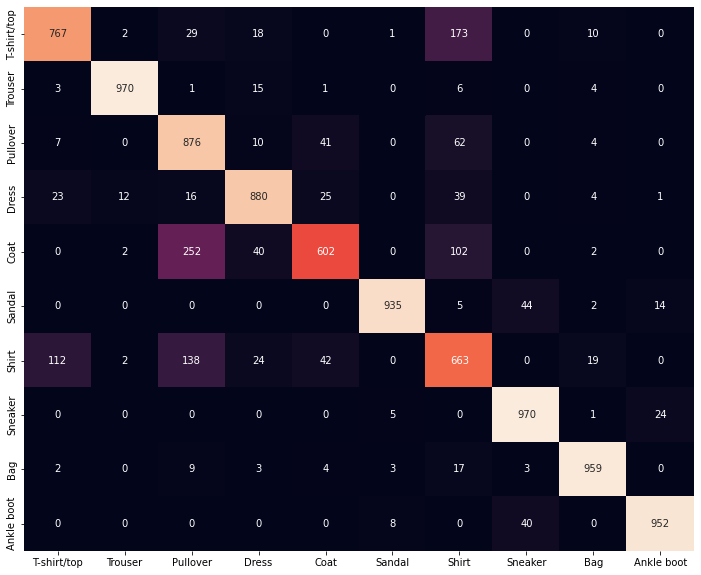

In [56]:
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_map.values() , yticklabels=label_map.values(), cbar=False)

## prediction on our model

In [57]:
data = next(iter(test_data_loader))

In [58]:
## data will be containing images and labels
images, labels = data

In [59]:
## image shape
images.shape

torch.Size([32, 1, 28, 28])

- 32 is batch size
- 1 is for gray channel
- 28 X 28 is size of image

In [60]:
## one any random image
idx = 2
img = images[idx]
img.shape

torch.Size([1, 28, 28])

In [61]:
## one image label
label = labels[idx]
label_map[label.item()]

'Trouser'

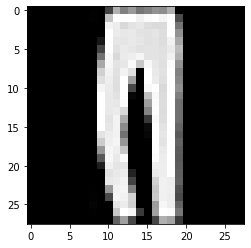

In [62]:
## visualize image
plt.imshow(img.squeeze(), cmap="gray")

In [63]:
## opposite of squeeze is unsqueeze
img.unsqueeze(dim=1).shape

torch.Size([1, 1, 28, 28])

In [64]:
## doing prediction for one image
## it will return logit for each class
logit = model(img.unsqueeze(dim=1).to(config.DEVICE))
logit

tensor([[   9.3817,   31.0267,  -19.0522,   -3.4182,   -8.2361,  -85.7567,
          -14.9228, -282.4249,   -3.5938, -128.5899]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [65]:
## if you sum all logits, they will not equal to 1 because these are not probability,
## we need to convert these logits into probability by using softmax
sum([1.9107, 32.9941, -36.2391, -12.3562, -45.1147, -144.5987, -9.1314,  -82.8379,  -24.2255, -118.4811])

-438.0798

In [66]:
pred_prob = F.softmax(logit, dim=1)
pred_prob

tensor([[3.9783e-10, 1.0000e+00, 1.7824e-22, 1.0984e-15, 8.8791e-18, 0.0000e+00,
         1.1076e-20, 0.0000e+00, 9.2151e-16, 0.0000e+00]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

In [67]:
## now if we sum all prediction probability, these will sum to 1
sum([3.1670e-14, 1.0000e+00, 8.5586e-31, 2.0167e-20, 1.1961e-34, 0.0000e+00, 5.0714e-19, 0.0000e+00, 1.4121e-25, 0.0000e+00])

1.0000000000000318

In [68]:
## use argmax to find maximum probability
## argxmax will return index of class having maximum probability
argmax = torch.argmax(pred_prob).item()
argmax 

1

In [69]:
## label for the precdicted class
label_map[argmax]

'Trouser'

In [70]:
## will make a function for prediction using all above steps

def predict(data, model, label_map, device, idx=0):
  images, labels = data
  img = images[idx]
  label = labels[idx]

  plt.imshow(img.squeeze(), cmap="gray")
  logit = model(img.unsqueeze(dim=1).to(config.DEVICE))
  pred_prob = F.softmax(logit, dim=1)
  argmax = torch.argmax(pred_prob).item()
  
  predicted_label = label_map[argmax]
  actual_label = label_map[label.item()]

  plt.title(f"actual: {actual_label} | predicted: {predicted_label}")
  plt.axis("off")
  return predicted_label, actual_label

('Trouser', 'Trouser')

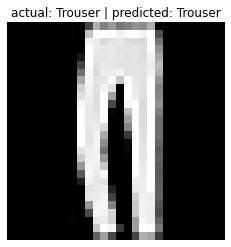

In [71]:
predict(data, model, label_map, config.DEVICE, idx=2)

In [72]:
print(f"{80* '-'}This is the End for this notebook {30* '-'}")

--------------------------------------------------------------------------------This is the End for this notebook ------------------------------


In [73]:
## importing time lib
import time

## declaring some useful variables
total_pushups = 50
pushups_done = 0

for pushup in range(total_pushups):
  pushup = pushup + 1
  time.sleep(1)
  pushups_done += 1
  print(f"{pushup} pushup completed..")

  if  pushups_done == total_pushups:
    print("Congratulations! You made it")
    break

  if pushups_done % 10 == 0:
    user_response = input("Are you tired? ")
    if user_response in ("y", "Y", "yes", "YES"):
      print(f"You did total {pushups_done} push-ups")
      break
    else:
      pushups_remaining = total_pushups - pushups_done
      print(f"{pushups_remaining} push-ups remaining")


1 pushup completed..
2 pushup completed..
3 pushup completed..
4 pushup completed..
5 pushup completed..
6 pushup completed..
7 pushup completed..
8 pushup completed..
9 pushup completed..
10 pushup completed..
Are you tired? y
You did total 10 push-ups


In [74]:
2%2

0